<a href="https://colab.research.google.com/github/Alex-Chen1121/Deep-Leaning/blob/main/Imbalanced_Data_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

import torch
from torch import nn
import torchvision
from torchvision import models, transforms
from torchsummary import summary

In [ ]:
# Download dataset from GoogleDrive
!pip install --upgrade gdown
!gdown --id 1kIef9G5Og7VgDPEHt_vIJMTKHdC7_0Kq --output "./NEU_defect.zip"
!unzip -q "./NEU_defect.zip"

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1kIef9G5Og7VgDPEHt_vIJMTKHdC7_0Kq
From (redirected): https://drive.google.com/uc?id=1kIef9G5Og7VgDPEHt_vIJMTKHdC7_0Kq&confirm=t&uuid=65ae429f-ef03-4262-a08c-371a383aef99
To: /content/NEU_defect.zip
100% 56.8M/56.8M [00:01<00:00, 36.2MB/s]


In [ ]:
paths = glob(f"./NEU_defect/*.bmp")
len(paths)
# 6個類別 各300張

1800

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')
IMG_SIZE = 200 # 128
class_names = ['PS', 'Sc', 'RS', 'In', 'Cr', 'Pa']
class_map = {cls: i for i, cls in enumerate(class_names)}
print(class_map)
NUM_CLASS = len(class_names)

# 將各類別資料數量調整成inbalance資料集
sample_size = [300, 200, 100, 50, 50, 50]

device: cuda
{'PS': 0, 'Sc': 1, 'RS': 2, 'In': 3, 'Cr': 4, 'Pa': 5}


In [ ]:
df = pd.DataFrame()
df["path"] = paths
df["cls_name"] = [path.split('/')[-1].split('_')[0] for path in paths]
df["cls"] = [class_map[name] for name in df["cls_name"]]

df

,path,cls_name,cls
0,./NEU_defect/Cr_31.bmp,Cr,4
1,./NEU_defect/RS_72.bmp,RS,2
2,./NEU_defect/RS_148.bmp,RS,2
3,./NEU_defect/Cr_167.bmp,Cr,4
4,./NEU_defect/In_249.bmp,In,3
...,...,...,...
1795,./NEU_defect/PS_192.bmp,PS,0
1796,./NEU_defect/In_290.bmp,In,3
1797,./NEU_defect/PS_50.bmp,PS,0
1798,./NEU_defect/PS_118.bmp,PS,0


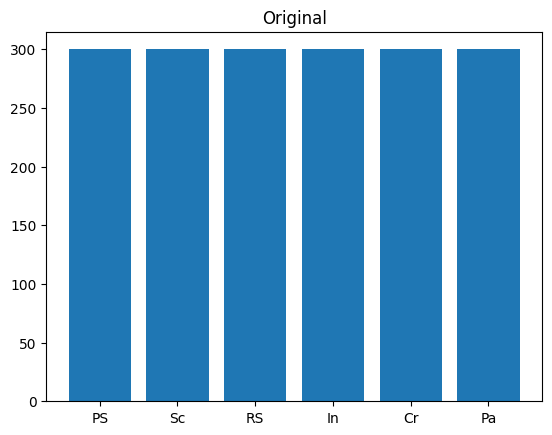

In [ ]:
# 原始資料分布
def plot_dist(column, title=''):
    cls, counts = np.unique(column, return_counts=True)
    plt.bar(class_names, counts)
    plt.title(title)
    plt.show()

plot_dist(df["cls"], 'Original')

In [ ]:
def resample(df, sample_sizes, replace=False):
    df_resample = pd.DataFrame()

    for i, count in enumerate(sample_sizes):
        df_resample = pd.concat([df_resample, df[df["cls"]==i].sample(count, replace=replace)])
    df_resample = df_resample.reset_index(drop=True)
    return df_resample

df_resample = resample(df, sample_size)
df_resample.head()

,path,cls_name,cls
0,./NEU_defect/PS_130.bmp,PS,0
1,./NEU_defect/PS_178.bmp,PS,0
2,./NEU_defect/PS_21.bmp,PS,0
3,./NEU_defect/PS_169.bmp,PS,0
4,./NEU_defect/PS_162.bmp,PS,0


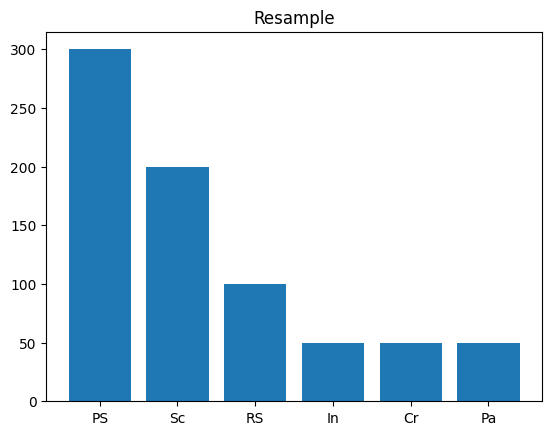

In [ ]:
plot_dist(df_resample["cls"], title='Resample')

#### Resample to target distribution

In [ ]:
target_size = [150, 150, 150, 150, 150, 150]
df_target = resample(df_resample, target_size, replace=True)
df_target.head()

,path,cls_name,cls
0,./NEU_defect/PS_288.bmp,PS,0
1,./NEU_defect/PS_54.bmp,PS,0
2,./NEU_defect/PS_292.bmp,PS,0
3,./NEU_defect/PS_193.bmp,PS,0
4,./NEU_defect/PS_188.bmp,PS,0


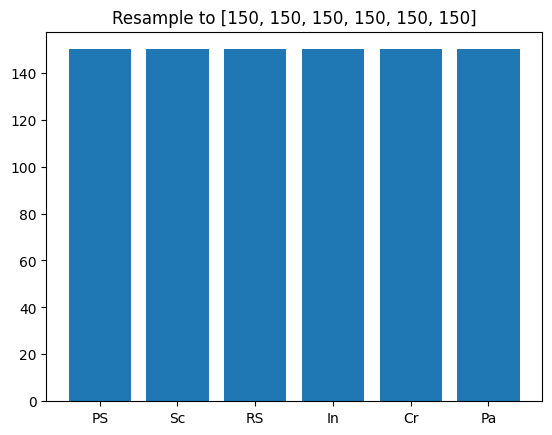

In [ ]:
plot_dist(df_target["cls"], f"Resample to {target_size}")

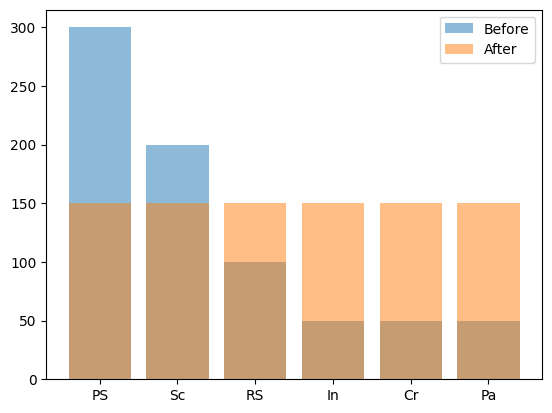

In [ ]:
cls, counts = np.unique(df_resample["cls"], return_counts=True)
plt.bar(class_names, counts, alpha=0.5)
cls, counts = np.unique(df_target["cls"], return_counts=True)
plt.bar(class_names, counts, alpha=0.5)
plt.legend(["Before", "After"])
plt.show()

#### Split dataset (**Stratify**)

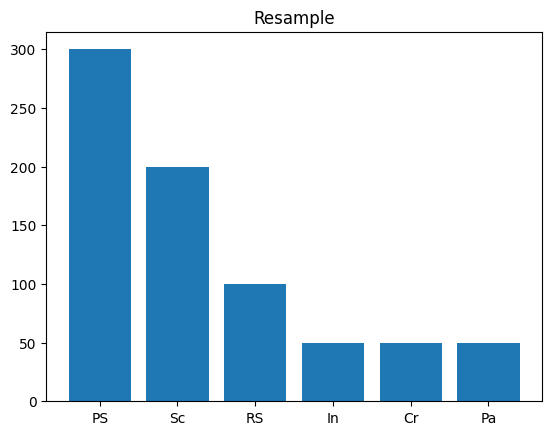

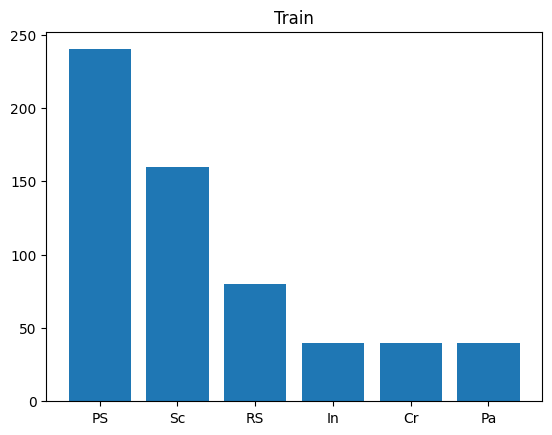

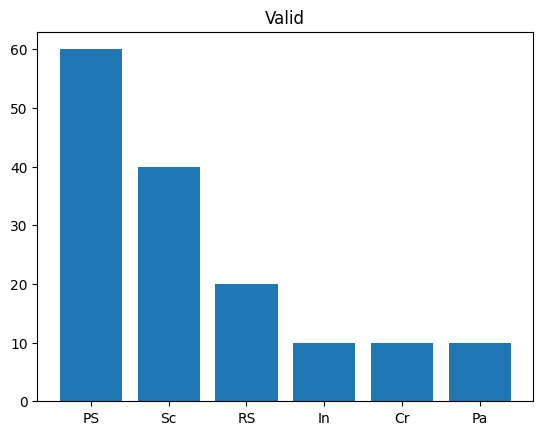

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_resample,
    test_size=0.2,
    random_state=5566,
    stratify=df_resample["cls"] # 維持切分的比重
)

plot_dist(df_resample["cls"], 'Resample')
plot_dist(df_train["cls"], 'Train')
plot_dist(df_val["cls"], 'Valid')

In [ ]:
df_train, df_val = train_test_split(df_target,
    stratify=df_target["cls"]
)

plot_dist(df_target["cls"], 'Target')
plot_dist(df_train["cls"], 'Target Train')
plot_dist(df_val["cls"], 'Target Valid')

#### Dataset

In [ ]:
class NEUDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_size):
        self.df = df
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 讀取圖片(資料用dataframe)
        row = self.df.iloc[idx]
        img = cv2.imread(row["path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.

        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        cls_idx = torch.tensor(row["cls"], dtype=torch.int64)
        return img, cls_idx

tensor(3)


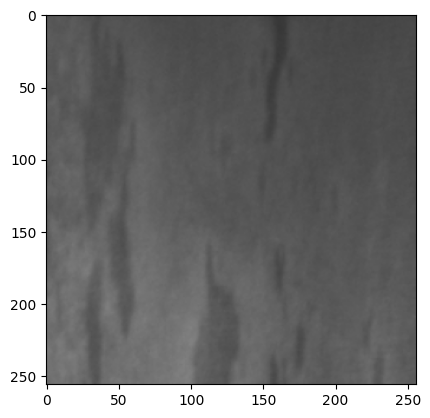

In [ ]:
train_ds = NEUDataset(df_train, 256)
val_ds = NEUDataset(df_val, 256)

x, y = train_ds[0]

print(y)
plt.imshow(x.permute(1, 2, 0))
plt.show()

In [ ]:
BS = 32
train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BS)

### Build Model

In [ ]:
model = models.resnet18()
model.fc = nn.Linear(512, NUM_CLASS)

### Training

Class Weight

In [ ]:
CLASS_WEIGHT = True
if CLASS_WEIGHT:
    # 類別比重計算
    sample_size = np.array(sample_size)
    data_count = np.unique(sample_size, return_counts=True)[1]
    # 反比 資料數量越多 比重越低
    weights = (1/sample_size) * np.sum(sample_size) / NUM_CLASS
    print('Use Class Weight')
    print('sample_size: ', sample_size)
    print('weights: ', weights)
    weights = torch.tensor(weights, dtype=torch.float).to(device)
    loss_fn = nn.CrossEntropyLoss(weight=weights)
else:
    loss_fn = nn.CrossEntropyLoss() # 平常使用的損失函數

Use Class Weight
sample_size:  [300 200 100  50  50  50]
weights:  [0.41666667 0.625      1.25       2.5        2.5        2.5       ]


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    epoch_loss = 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params
        epoch_loss += loss.item() # 轉tesor值
    return epoch_loss/num_batches

def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.eval() # 將模型轉到測試
    epoch_loss = 0
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            epoch_loss += loss.item()
    return epoch_loss/num_batches


model = model.to(device)
EPOCHS = 20
logs = {'train_loss': [], 'val_loss': []}
# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_epoch(train_loader, model, loss_fn, optimizer)
    val_loss = test_epoch(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f} val_loss: {val_loss:.4f}')

    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)


    torch.save(model.state_dict(), "last.pth")
    # 計算次數
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 1.2144 val_loss: 3.8683


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 0.9631 val_loss: 2.5063


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 0.7456 val_loss: 7.7281


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 0.6345 val_loss: 1.9609


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 0.4951 val_loss: 20.8864


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.5817 val_loss: 2.8436


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.3745 val_loss: 15.1163


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.3429 val_loss: 3.7583


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.2870 val_loss: 2.3382
Earlystop!


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 0.4533 val_loss: 4.0787
Earlystop!


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 0.3263 val_loss: 0.4912


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 0.3785 val_loss: 12.2734


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 0.2812 val_loss: 14.2412


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 0.2024 val_loss: 1.9149


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 0.2248 val_loss: 8.6374


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 0.2629 val_loss: 1.7859
Earlystop!


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 0.2566 val_loss: 21.2807
Earlystop!


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 0.1910 val_loss: 6.8359
Earlystop!


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0018     train_loss: 0.1692 val_loss: 2.6823
Earlystop!


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH: 0019     train_loss: 0.2468 val_loss: 2.6535
Earlystop!


#### Evaluation

In [ ]:
model.load_state_dict(torch.load("best.pth"))
_ = model.eval()

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

def evaluation(model, test_loader):
    # 暫時存放區tensor
    y_true = torch.tensor([], dtype=torch.long).to(device)
    y_pred_logits = torch.tensor([]).to(device)

    # 預測不需要梯度下降
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            # 結合預測值及實際答案
            y_true = torch.cat((y_true, y), dim=0)
            y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

    y_preds = y_pred_logits.argmax(1)
    y_trues = y_true.cpu().numpy()
    y_preds = y_preds.cpu().numpy()

    # 印出分類報告
    print(classification_report(y_trues, y_preds, digits=4,
                                target_names=class_names))


evaluation(model, val_loader)

              precision    recall  f1-score   support

          PS     0.8361    0.8500    0.8430        60
          Sc     0.9487    0.9250    0.9367        40
          RS     1.0000    0.8000    0.8889        20
          In     0.4615    0.6000    0.5217        10
          Cr     0.8889    0.8000    0.8421        10
          Pa     0.8333    1.0000    0.9091        10

    accuracy                         0.8533       150
   macro avg     0.8281    0.8292    0.8236       150
weighted avg     0.8663    0.8533    0.8570       150



In [ ]:
"""              precision    recall  f1-score   support

          PS     0.8308    0.9000    0.8640        60
          Sc     0.6316    0.9000    0.7423        40
          RS     0.7273    0.8000    0.7619        20
          In     1.0000    0.2000    0.3333        10
          Cr     1.0000    0.4000    0.5714        10
          Pa     0.0000    0.0000    0.0000        10

    accuracy                         0.7467       150
   macro avg     0.6983    0.5333    0.5455       150
weighted avg     0.7310    0.7467    0.7054       150"""

'              precision    recall  f1-score   support\n\n          PS     0.8308    0.9000    0.8640        60\n          Sc     0.6316    0.9000    0.7423        40\n          RS     0.7273    0.8000    0.7619        20\n          In     1.0000    0.2000    0.3333        10\n          Cr     1.0000    0.4000    0.5714        10\n          Pa     0.0000    0.0000    0.0000        10\n\n    accuracy                         0.7467       150\n   macro avg     0.6983    0.5333    0.5455       150\nweighted avg     0.7310    0.7467    0.7054       150'

In [ ]:
'''
              precision    recall  f1-score   support

          PS     0.7763    0.9833    0.8676        60
          Sc     0.9474    0.9000    0.9231        40
          RS     1.0000    0.6000    0.7500        20
          In     1.0000    0.1000    0.1818        10
          Cr     0.7143    1.0000    0.8333        10
          Pa     1.0000    0.9000    0.9474        10

accuracy                         0.8467       150
macro avg     0.9063    0.7472    0.7505       150
weighted avg     0.8774    0.8467    0.8240       150
'''

'\n              precision    recall  f1-score   support\n\n          PS     0.7763    0.9833    0.8676        60\n          Sc     0.9474    0.9000    0.9231        40\n          RS     1.0000    0.6000    0.7500        20\n          In     1.0000    0.1000    0.1818        10\n          Cr     0.7143    1.0000    0.8333        10\n          Pa     1.0000    0.9000    0.9474        10\n\n    accuracy                         0.8467       150\n   macro avg     0.9063    0.7472    0.7505       150\nweighted avg     0.8774    0.8467    0.8240       150\n'